### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [15]:
# You will need to download any word embeddings required for your code, e.g.:

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!pip install transformers
# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch

--2021-02-28 23:48:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-28 23:48:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-28 23:48:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
import transformers
from keras.preprocessing.sequence import pad_sequences
import re
import math
import torch.nn.functional as F

In [4]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [5]:
# Load data
train_df = pd.read_csv('./drive/MyDrive/Colab Notebooks/Imperial - NLP/data/train.csv')
dev_df = pd.read_csv('./drive/MyDrive/Colab Notebooks/Imperial - NLP/data/dev.csv')
test_df = pd.read_csv('./drive/MyDrive/Colab Notebooks/Imperial - NLP/data/test.csv')

In [6]:
# replace original word with edited word
def get_edited_df(df):
    df_copy = df.copy(deep=True)
    df_copy['edited'] = df_copy['original']
    df_copy['edited'] = df_copy.apply(lambda x: re.sub(r"(<[^>]+>)", x['edit'], x['edited']), axis=1)
    return df_copy

train_df = get_edited_df(train_df)
dev_df = get_edited_df(dev_df)
test_df = get_edited_df(test_df)

In [7]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8

# batch_size
BATCH_SIZE = 32

In [8]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, method=None):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    
    print("Training model.")
    if method == 'bert':
        train_loss = []
        eval_loss = []

        for epoch in range(1, number_epoch+1):
            model.train()
            epoch_loss = 0
            epoch_sse = 0
            no_observations = 0

            for batch in train_iter:
                feature, target, mask = batch
                
                feature, target, mask = feature.to(device), target.to(device), mask.to(device)
                model.batch_size = target.shape[0]
                no_observations += target.shape[0]
                output = model(feature, attention_mask=mask, labels=target)
                predictions = output.logits.squeeze(1)

                optimizer.zero_grad()
                loss = loss_fn(predictions, target)

                sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse
            
            valid_loss, valid_mse, __, __ = eval(dev_iter, model, method=method)

            epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
            
            train_loss += [epoch_loss]
            eval_loss += [valid_loss]
            
            print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
            Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')
 #       torch.save(model.state_dict(), './drive/MyDrive/NLP_CW/bert.pth')
 #       np.save('./drive/MyDrive/NLP_CW/train_loss.npy', train_loss)
 #       np.save('./drive/MyDrive/NLP_CW/eval_loss.npy', eval_loss)
    else:
        train_losses = []
        eval_losses = []
        train_mse = []
        eval_mse = []
        
        print("Training model.")

        for epoch in range(1, number_epoch+1):

            model.train()
            epoch_loss = 0
            epoch_sse = 0
            no_observations = 0  # Observations used for training so far

            for batch in train_iter:

                feature, target = batch

                feature, target = feature.to(device), target.to(device)

                # for RNN:
                model.batch_size = target.shape[0]
                no_observations = no_observations + target.shape[0]
                #model.hidden = model.init_hidden()

                predictions = model(feature).squeeze(1)

                optimizer.zero_grad()

                loss = loss_fn(predictions, target)

                sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse

            valid_loss, valid_mse, __, __ = eval(dev_iter, model)
            epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations

            train_losses.append(epoch_loss)
            eval_losses.append(valid_loss)
            train_mse.append(epoch_mse)
            eval_mse.append(valid_mse)
            
            print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
            Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')
        
        #torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/Imperial - NLP/model.pth')

        return train_losses, eval_losses, train_mse, eval_mse

In [9]:
# We evaluate performance on our dev set
def eval(data_iter, model, method=None):
    """
    Evaluating model performance on the dev set
    """
    if method == 'bert':
        model.eval()
        epoch_loss = 0
        epoch_sse = 0
        pred_all = []
        trg_all = []
        no_observations = 0

        with torch.no_grad():
            for batch in data_iter:
                feature, target, mask = batch

                feature, target, mask = feature.to(device), target.to(device), mask.to(device)

            # for RNN:
                model.batch_size = target.shape[0]
                no_observations = no_observations + target.shape[0]
                output = model(feature, attention_mask=mask, labels=target)
                predictions = output.logits.squeeze(1)

                loss = loss_fn(predictions, target)

            # We get the mse
                pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
                sse, __ = model_performance(pred, trg)

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse
                pred_all.extend(pred)
                trg_all.extend(trg)
    
    else:
        model.eval()
        epoch_loss = 0
        epoch_sse = 0
        pred_all = []
        trg_all = []
        no_observations = 0

        with torch.no_grad():
            for batch in data_iter:
                feature, target = batch

                feature, target = feature.to(device), target.to(device)

                # for RNN:
                model.batch_size = target.shape[0]
                no_observations = no_observations + target.shape[0]
                #model.hidden = model.init_hidden()

                predictions = model(feature).squeeze(1)
                loss = loss_fn(predictions, target)

                # We get the mse
                pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
                sse, __ = model_performance(pred, trg)

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse
                pred_all.extend(pred)
                trg_all.extend(trg)

        return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [10]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [11]:
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list

    for sentence in data:

        tokenized_sentence = []

        for token in sentence.split(' '): # simplest split is

            tokenized_sentence.append(token)

        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

In [18]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1DatasetBert(Dataset):

    def __init__(self, train_data, labels, mask):
        self.x_train = train_data
        self.y_train = labels
        self.mask = mask

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item], self.mask[item]

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

In [13]:
class attBiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(attBiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, dropout=0.3)
        self.label = nn.Linear(hidden_dim* 2, 1)
        self.dropout = nn.Dropout(0.3)

        # The linear layer that maps from hidden state space to tag space
        #self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        #self.hidden = self.init_hidden()

    def attNetwork(self, x, query):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        #return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
        #       torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

        query_dim = query.size(-1)
        alpha = torch.matmul(query, x.transpose(1, 2) / math.sqrt(query_dim))

        attn = F.softmax(alpha, dim = -1)
        context = torch.matmul(attn, x).sum(1)

        return context, attn

    def forward(self, sentence):             
        embedding = self.dropout(self.embedding(sentence))
        output, (final_hidden_state, final_cell_state) = self.lstm(embedding)

        query = self.dropout(output)
        attn_output, attn = self.attNetwork(output, query)
        logit = self.label(attn_output)
 #       print(logit.shape)
        return logit

In [30]:
## Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = train_df['edited']
test_data = dev_df['edited']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))

print("Vocab created.")

# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

# This is a large file, it will take a while to load in the memory!
with codecs.open('glove.6B.100d.txt', 'r','utf-8') as f:
  index = 0
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_tokenized_corpus]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

Vocab created.


In [41]:
INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 100
BATCH_SIZE = 32

model = attBiLSTM(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

feature = vectorized_seqs

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset(feature, train_df['meanGrade'])
dev_dataset = Task1Dataset(feature, dev_df['meanGrade'])
test_dataset = Task1Dataset(feature, test_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.02)

train_losses, eval_losses, train_mse, eval_mse = train(train_loader, dev_loader, model, epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Model initialised.
Dataloaders created.
Training model.
Training model.
| Epoch: 01 | Train Loss: 0.47 | Train MSE: 0.47 | Train RMSE: 0.69 |             Val. Loss: 0.39 | Val. MSE: 0.39 |  Val. RMSE: 0.62 |
| Epoch: 02 | Train Loss: 0.39 | Train MSE: 0.39 | Train RMSE: 0.63 |             Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 |
| Epoch: 03 | Train Loss: 0.38 | Train MSE: 0.38 | Train RMSE: 0.62 |             Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 |
| Epoch: 04 | Train Loss: 0.38 | Train MSE: 0.38 | Train RMSE: 0.61 |             Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 |
| Epoch: 05 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |             Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 |
| Epoch: 06 | Train Loss: 0.38 | Train MSE: 0.38 | Train RMSE: 0.61 |             Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 |
| Epoch: 07 | Train Loss: 0.38 | Train MSE: 0.38 | Train RMSE: 0.61 |             Val. Loss: 0.37 | Val. MSE: 0.

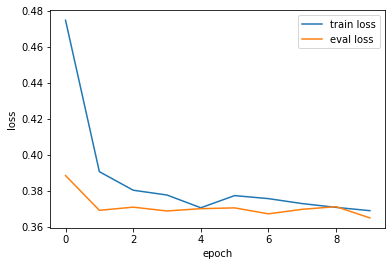

In [42]:
# draw training curve
import matplotlib.pyplot as plt

plt.figure()
x = list(range(len(train_losses)))
plt.plot(x, train_losses)
plt.plot(x, eval_losses)
plt.legend(['train loss', 'eval loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [40]:
test_loss, test_mse, __, __ = eval(test_loader, model)
print('whole test data, test loss{:.6f}, test rmse{:.6f}'.format(test_loss, test_mse**0.5))

whole test data, test loss0.352113, test rmse0.593391


# Part 1 Second Experiment

In [ ]:
MaxLen = 40

# create dataloader
def create_dataloader(df):
    data = df['edited']
    model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')

    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    data_tokenized = data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    data_tokenized = pad_sequences(data_tokenized, maxlen=MaxLen, dtype='long', value=0, truncating='post')
    print('setence tokenized and padded.')
    attention_mask = []
    for token in data_tokenized:
        att_mask = [int(token_id > 0) for token_id in token]
        attention_mask.append(att_mask)

    data_tokenized = torch.tensor(data_tokenized)
    label = torch.tensor(df['meanGrade'].values, dtype=torch.float32)
    attention_mask = torch.tensor(attention_mask, dtype=torch.int32)
    dataset = Task1DatasetBert(data_tokenized, label, attention_mask)
    loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)
    print('data loader created.')
    return loader

train_loader = create_dataloader(train_df)
dev_loader = create_dataloader(dev_df)
test_loader = create_dataloader(test_df)


setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.


In [ ]:
# define and train model
model = transformers.BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                   num_labels=1,
                                                                   output_attentions=False,
                                                                   output_hidden_states=False)
model.hidden_dropout_prob = 0.3
model.attention_dropout_prob = 0.3
model.cuda()

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.03)

train(train_loader, dev_loader, model, epochs, 'bert')


setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training model.
| Epoch: 01 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |             Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 02 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.58 |             Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 03 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.57 |             Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.56 |
| Epoch: 04 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.58 |             Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 05 | Train Loss: 0.32 | Train MSE: 0.32 | Train RMSE: 0.57 |             Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.56 |
| Epoch: 06 | Train Loss: 0.32 | Train MSE: 0.32 | Train RMSE: 0.57 |             Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 07 | Train Loss: 0.32 | Train MSE: 0.32 | Train RMSE: 0.57 |             Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 08 | Train Loss: 0.32 |

In [ ]:
model = transformers.BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                   num_labels=1,
                                                                   output_attentions=False,
                                                                   output_hidden_states=False)
model.load_state_dict(torch.load('./drive/MyDrive/NLP_CW/bert.pth'))
model.to(device)
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

test_df = test_df.sort_values(by=['meanGrade'])
n_samples = test_df.shape[0]
test10 = pd.concat([test_df[:int(0.1*n_samples)], test_df[int(0.9*n_samples):]])
test20 = pd.concat([test_df[:int(0.2*n_samples)], test_df[int(0.8*n_samples):]])
test30 = pd.concat([test_df[:int(0.3*n_samples)], test_df[int(0.7*n_samples):]])
test40 = pd.concat([test_df[:int(0.4*n_samples)], test_df[int(0.6*n_samples):]])

test_loader10 = create_dataloader(test10)
test_loader20 = create_dataloader(test20)
test_loader30 = create_dataloader(test30)
test_loader40 = create_dataloader(test40)
loaders = [test_loader, test_loader10, test_loader20, test_loader30, test_loader40]
for i, loader in enumerate(loaders):
    test_loss, test_mse, __, __ = eval(loader, model, 'bert')
    if i == 0:
        print('whole test data, test loss{:.6f}, test rmse{:.6f}'.format(test_loss, test_mse**0.5))
    else:
        print('{:2f} test data, test loss{:.6f}, test rmse{:.6f}'.format(0.1*i, test_loss, test_mse**0.5))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.
whole test data, test loss0.317227, test rmse0.563229
0.100000 test data, test loss0.879384, test rmse0.937755
0.200000 test data, test loss0.630693, test rmse0.794162
0.300000 test data, test loss0.483561, test rmse0.695385
0.400000 test data, test loss0.386061, test rmse0.621338


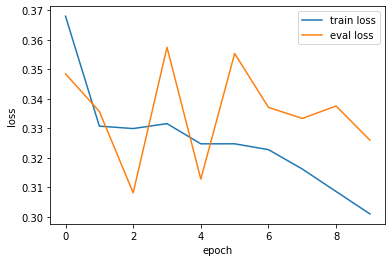

In [ ]:
# draw training curve
import matplotlib.pyplot as plt
plt.figure()
train_loss = np.load('./drive/MyDrive/NLP_CW/train_loss.npy')
eval_loss = np.load('./drive/MyDrive/NLP_CW/eval_loss.npy')
x = list(range(len(train_loss)))
plt.plot(x, train_loss)
plt.plot(x, eval_loss)
plt.legend(['train loss', 'eval loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


#### Approach 2: No pre-trained representations

In [ ]:
train_and_dev = train_df['edit']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.13 | RMSE: 0.37 |

Dev performance:
| MSE: 0.36 | RMSE: 0.60 |


#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)


Baseline performance:
| MSE: 0.34 | RMSE: 0.58 |
